In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/conversational-question-answering-dataset-coqa/coqa-dev-v1.0.json
/kaggle/input/conversational-question-answering-dataset-coqa/coqa-train-v1.0.json


In [2]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForQuestionAnswering, get_scheduler
from torch.optim import AdamW
from datasets import load_dataset

2025-07-08 14:20:11.174333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751984411.423846      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751984411.498439      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

# Preprocessing the json data

In [5]:
def get_df(fname):
    with open(fname, 'r') as file:
        f = json.load(file)
        
    return pd.DataFrame(f['data'])
import json

In [6]:
df = get_df('/kaggle/input/conversational-question-answering-dataset-coqa/coqa-train-v1.0.json')
dev_df = get_df('/kaggle/input/conversational-question-answering-dataset-coqa/coqa-dev-v1.0.json')

df.shape, dev_df.shape

((7199, 7), (500, 8))

In [7]:
df.head(3)

,source,id,filename,story,questions,answers,name
0,wikipedia,3zotghdk5ibi9cex97fepx7jetpso7,Vatican_Library.txt,"The Vatican Apostolic Library (), more commonl...",[{'input_text': 'When was the Vat formally ope...,"[{'span_start': 151, 'span_end': 179, 'span_te...",Vatican_Library.txt
1,cnn,3wj1oxy92agboo5nlq4r7bndc3t8a8,cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...,New York (CNN) -- More than 80 Michael Jackson...,"[{'input_text': 'Where was the Auction held?',...","[{'span_start': 243, 'span_end': 284, 'span_te...",cnn_fe05c61a7e48461f7883cdec387567029614f07b.s...
2,gutenberg,3bdcf01ogxu7zdn9vlrbf2rqzwplyf,data/gutenberg/txt/Zane Grey___Riders of the P...,"CHAPTER VII. THE DAUGHTER OF WITHERSTEEN \n\n""...",[{'input_text': 'What did Venters call Lassite...,"[{'span_start': 841, 'span_end': 880, 'span_te...",data/gutenberg/txt/Zane Grey___Riders of the P...


In [8]:
df.loc[0, 'story'].replace('\n', '')

'The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475, although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online. The Vatican Secret Archives were separated from the library at the beginning of the 17th cent

In [9]:
def clean_df(df):
    # we need only story question and answer column
    data = {
        'stories' : [],
        'questions' : [],
        'answers' : [],
        'span_start' : [],
        'span_end' : [],
    }
    
    for r in df.iterrows():
        ques_leng = len(r[1].questions)
        for i in range(ques_leng):
            data['stories'].append(r[1].story.replace('\n', ''))
            data['questions'].append(r[1]["questions"][i]['input_text'].replace('\n', ''))
            data['answers'].append(r[1]['answers'][i]['input_text'].replace('\n', ''))
            data['span_start'].append(r[1]['answers'][i]['span_start'])
            data['span_end'].append(r[1]['answers'][i]['span_end'])
            
    return pd.DataFrame(data)
      

In [10]:
df = clean_df(df)
dev_df = clean_df(dev_df)

df.shape, dev_df.shape

((108647, 5), (7983, 5))

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


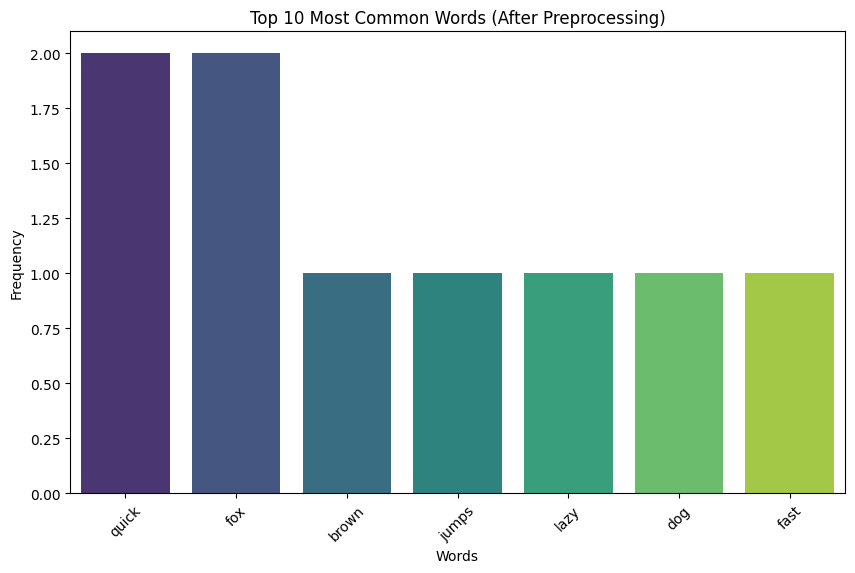

In [12]:
# Example text
text = "The quick brown fox jumps over the lazy dog. The quick fox was very fast."

# Preprocessing: Tokenization, stopword removal, and punctuation removal
stop_words = set(stopwords.words('english'))
tokens = word_tokenize(text.lower())
filtered_tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]

# Frequency distribution
word_freq = Counter(filtered_tokens)
most_common = word_freq.most_common(10)

# Plotting
words, counts = zip(*most_common)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(words), y=list(counts), palette='viridis')
plt.title("Top 10 Most Common Words (After Preprocessing)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


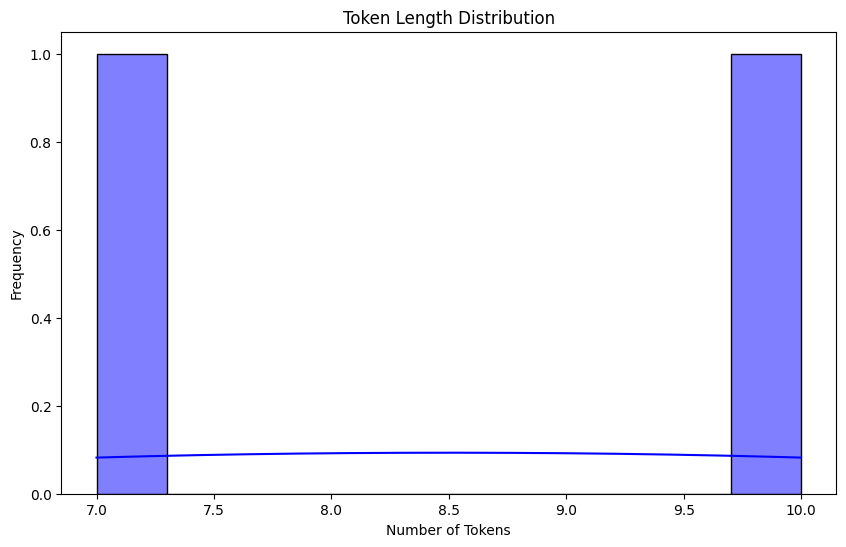

In [13]:
# Example text (multiple sentences)
texts = ["The quick brown fox jumps over the lazy dog.", "A bird flew across the sky."]

# Tokenize and compute token lengths
token_lengths = [len(word_tokenize(text)) for text in texts]

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(token_lengths, kde=True, color='blue', bins=10)
plt.title("Token Length Distribution")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


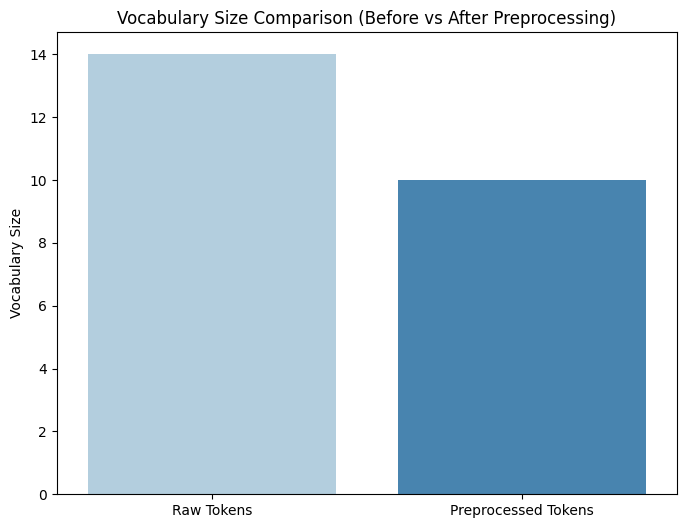

In [14]:
# Example text (multiple sentences)
texts = ["The quick brown fox jumps over the lazy dog.", "A bird flew across the sky."]

# Before preprocessing (raw tokens)
raw_tokens = [word_tokenize(text.lower()) for text in texts]
raw_vocab_size = len(set([word for sentence in raw_tokens for word in sentence]))

# After preprocessing (remove stopwords and punctuation)
stop_words = set(stopwords.words('english'))
filtered_tokens = [word for sentence in raw_tokens for word in sentence if word not in stop_words and word not in string.punctuation]
filtered_vocab_size = len(set(filtered_tokens))

# Plotting
vocab_sizes = [raw_vocab_size, filtered_vocab_size]
labels = ['Raw Tokens', 'Preprocessed Tokens']

plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=vocab_sizes, palette='Blues')
plt.title("Vocabulary Size Comparison (Before vs After Preprocessing)")
plt.ylabel("Vocabulary Size")
plt.show()

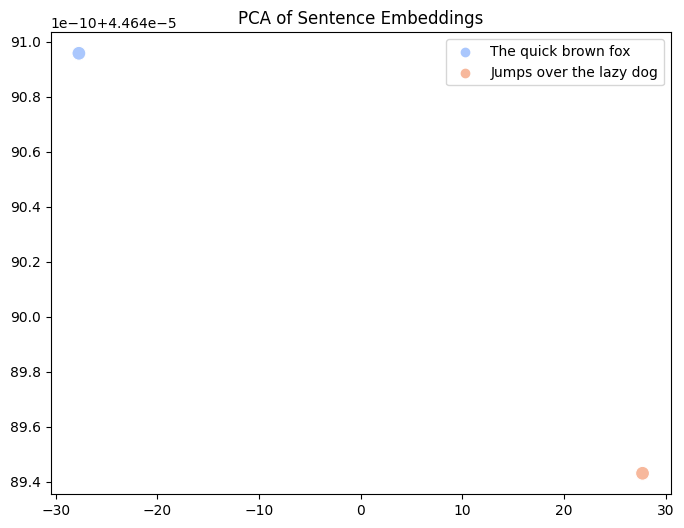

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from transformers import BertTokenizer, BertModel

# Example sentence to visualize embeddings
sentences = ["The quick brown fox", "Jumps over the lazy dog"]

# Load pre-trained BERT tokenizer and model for embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Get embeddings for sentences
embeddings = []
for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    embeddings.append(outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten())  # Take the mean of the token embeddings

embeddings = np.array(embeddings)

# Standardize and apply PCA
scaler = StandardScaler()
embeddings = scaler.fit_transform(embeddings)

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_embeddings[:, 0], y=reduced_embeddings[:, 1], palette='coolwarm', s=100, hue=sentences)
plt.title("PCA of Sentence Embeddings")
plt.show()


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


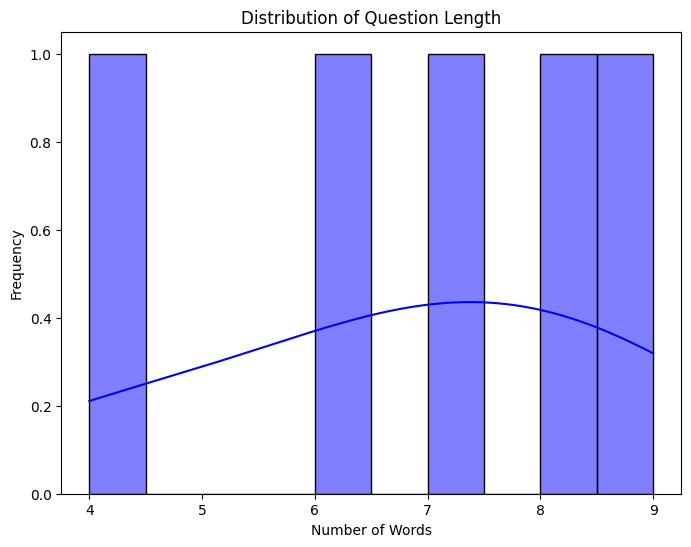

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


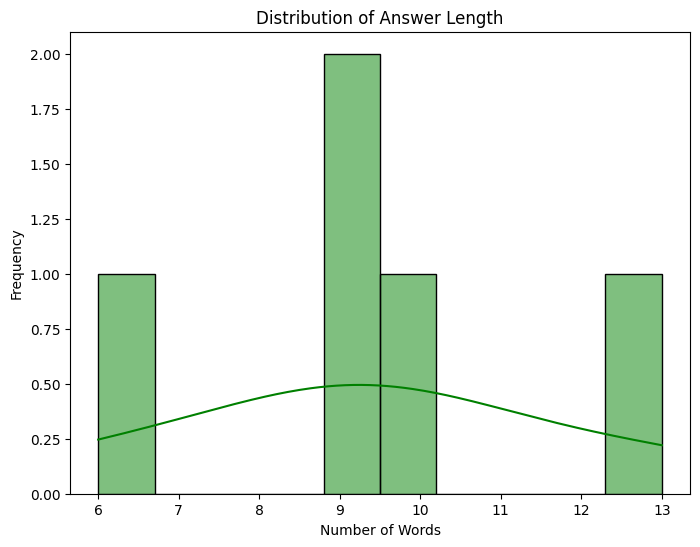

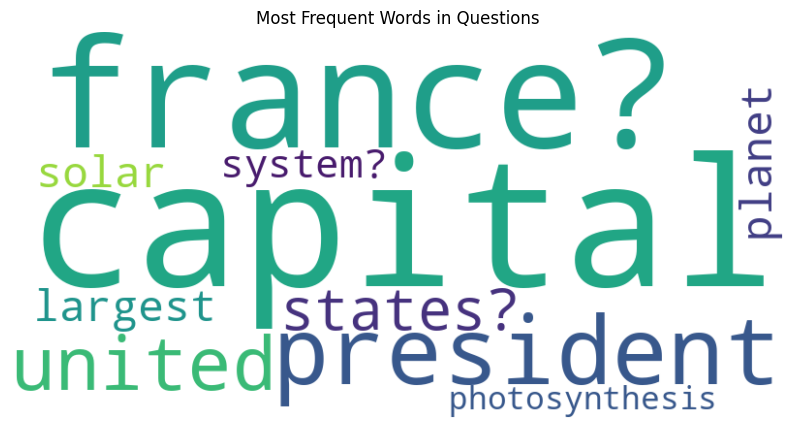

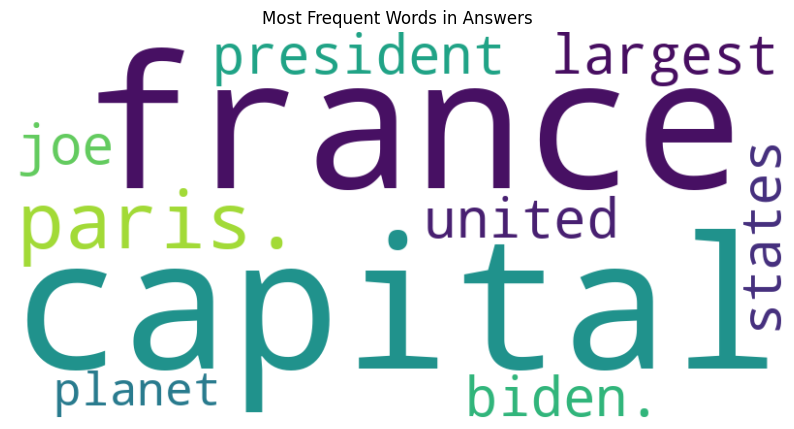

In [16]:

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Download stopwords
nltk.download('stopwords')

# Sample CoQA-like dataset structure
coqa_sample_data = {
    'question': [
        "What is the capital of France?",
        "Who is the president of the United States?",
        "What is the largest planet in our solar system?",
        "How does photosynthesis work?",
        "When was the Declaration of Independence signed?"
    ],
    'answer': [
        "The capital of France is Paris.",
        "The president of the United States is Joe Biden.",
        "The largest planet in our solar system is Jupiter.",
        "Photosynthesis is a process by which plants convert light energy into chemical energy.",
        "The Declaration of Independence was signed on July 4, 1776."
    ]
}

# Length of questions and answers
question_lengths = [len(q.split()) for q in coqa_sample_data['question']]
answer_lengths = [len(a.split()) for a in coqa_sample_data['answer']]

# Plot: Distribution of Question Length
plt.figure(figsize=(8, 6))
sns.histplot(question_lengths, kde=True, color='blue', bins=10)
plt.title("Distribution of Question Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Plot: Distribution of Answer Length
plt.figure(figsize=(8, 6))
sns.histplot(answer_lengths, kde=True, color='green', bins=10)
plt.title("Distribution of Answer Length")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Tokenizing questions and answers for word frequency analysis
all_questions = ' '.join(coqa_sample_data['question']).lower()
all_answers = ' '.join(coqa_sample_data['answer']).lower()

# Remove stopwords from the questions and answers
stop_words = set(stopwords.words('english'))

question_tokens = [word for word in all_questions.split() if word not in stop_words]
answer_tokens = [word for word in all_answers.split() if word not in stop_words]

# Most Frequent Words in Questions
question_word_freq = Counter(question_tokens)
top_question_words = question_word_freq.most_common(10)

# Most Frequent Words in Answers
answer_word_freq = Counter(answer_tokens)
top_answer_words = answer_word_freq.most_common(10)

# Plot: Most Frequent Words in Questions
question_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_question_words))
plt.figure(figsize=(10, 6))
plt.imshow(question_wordcloud, interpolation="bilinear")
plt.title("Most Frequent Words in Questions")
plt.axis('off')
plt.show()

# Plot: Most Frequent Words in Answers
answer_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_answer_words))
plt.figure(figsize=(10, 6))
plt.imshow(answer_wordcloud, interpolation="bilinear")
plt.title("Most Frequent Words in Answers")
plt.axis('off')
plt.show()


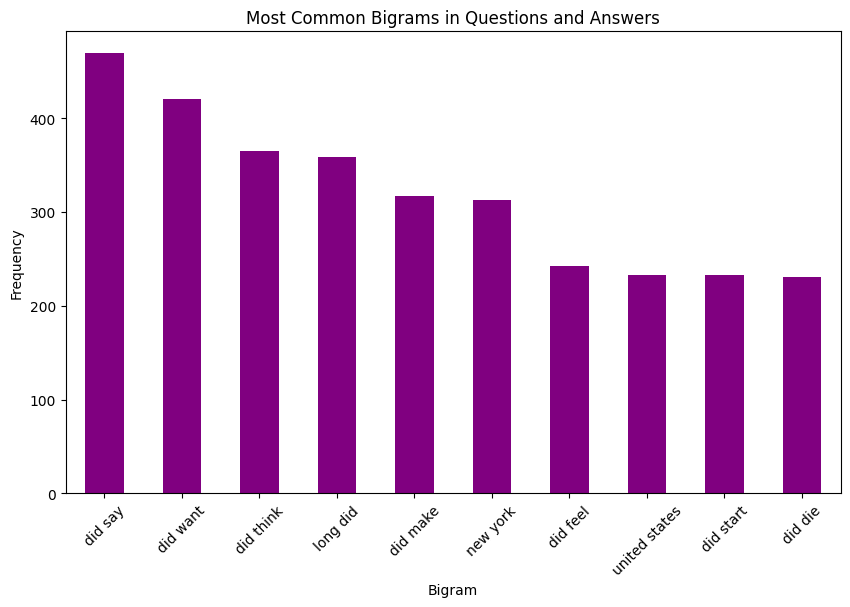

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(df['questions'] + ' ' + df['answers'])
bigram_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Sum up the counts for each bigram
bigram_counts = bigram_freq.sum().sort_values(ascending=False).head(10)

# Plot: Most Common Bigrams
plt.figure(figsize=(10, 6))
bigram_counts.plot(kind='bar', color='purple')
plt.title("Most Common Bigrams in Questions and Answers")
plt.xlabel("Bigram")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

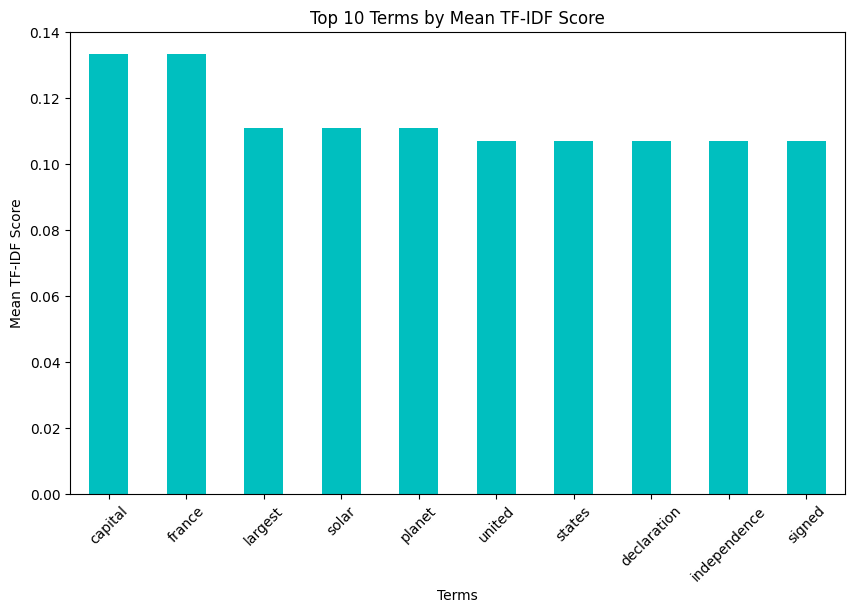

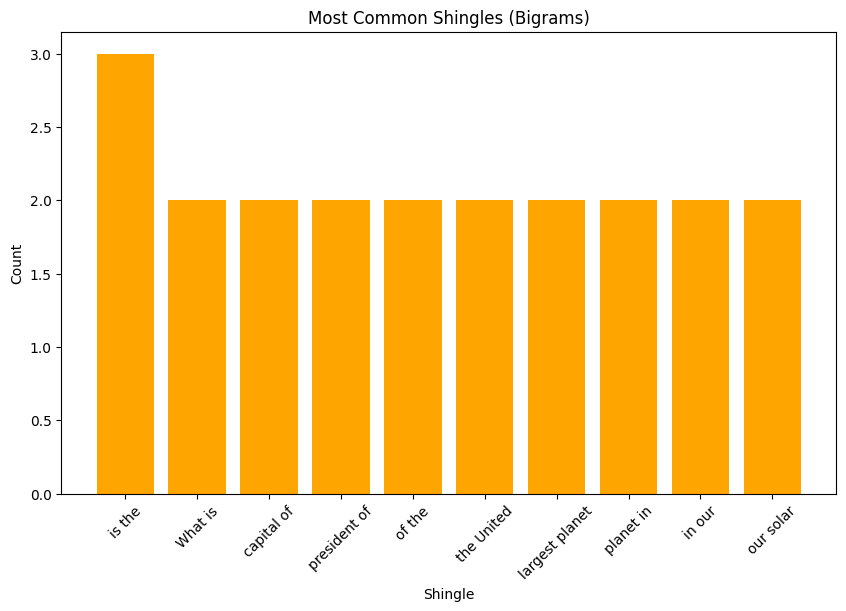

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from collections import Counter
import numpy as np

# Sample dataset for TF-IDF and shingles analysis
coqa_sample_data = {
    'question': [
        "What is the capital of France?",
        "Who is the president of the United States?",
        "What is the largest planet in our solar system?",
        "How does photosynthesis work?",
        "When was the Declaration of Independence signed?"
    ],
    'answer': [
        "The capital of France is Paris.",
        "The president of the United States is Joe Biden.",
        "The largest planet in our solar system is Jupiter.",
        "Photosynthesis is a process by which plants convert light energy into chemical energy.",
        "The Declaration of Independence was signed on July 4, 1776."
    ]
}

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(coqa_sample_data)

# --- TF-IDF Visualization ---
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['question'] + ' ' + df['answer'])

# Convert TF-IDF to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Plot: Most important terms (words) in the corpus based on TF-IDF
top_n = 10  # Top N terms to visualize
mean_tfidf_scores = tfidf_df.mean(axis=0).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mean_tfidf_scores.head(top_n).plot(kind='bar', color='c')
plt.title(f"Top {top_n} Terms by Mean TF-IDF Score")
plt.xlabel("Terms")
plt.ylabel("Mean TF-IDF Score")
plt.xticks(rotation=45)
plt.show()

# --- Shingles (N-grams) Visualization ---
def generate_shingles(text, n=2):
    words = text.split()
    shingles = [tuple(words[i:i+n]) for i in range(len(words)-n+1)]
    return shingles

# Create shingles for both questions and answers
shingles = []
for i, row in df.iterrows():
    question_shingles = generate_shingles(row['question'], n=2)  # bigrams
    answer_shingles = generate_shingles(row['answer'], n=2)
    shingles.extend(question_shingles)
    shingles.extend(answer_shingles)

# Count the most common shingles (bigrams)
shingle_counts = Counter(shingles)

# Get top 10 most common shingles
top_shingles = shingle_counts.most_common(10)
top_shingles

# Plot: Most common shingles (bigrams)
shingles, counts = zip(*top_shingles)
plt.figure(figsize=(10, 6))
plt.bar(range(len(top_shingles)), counts, tick_label=[' '.join(shingle) for shingle in shingles], color='orange')
plt.title("Most Common Shingles (Bigrams)")
plt.xlabel("Shingle")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# Loading the Bert Models 

In [21]:
import torch
from transformers import (
    BertForQuestionAnswering,
    BertTokenizer,
    RobertaForQuestionAnswering,
    RobertaTokenizer,
)
import re
import pandas as pd
from tqdm import tqdm

# ===================== Preprocessing & Metrics =====================

def normalize_text(s):
    s = s.lower()
    s = re.sub(r'\b(a|an|the)\b', ' ', s)
    s = re.sub(r'[^a-z0-9]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def compute_exact(pred, true):
    return int(normalize_text(pred) == normalize_text(true))

def compute_f1(pred, true):
    pred_tokens = normalize_text(pred).split()
    true_tokens = normalize_text(true).split()
    common = set(pred_tokens) & set(true_tokens)
    num_same = len(common)
    if len(pred_tokens) == 0 or len(true_tokens) == 0:
        return int(pred_tokens == true_tokens)
    if num_same == 0:
        return 0
    precision = num_same / len(pred_tokens)
    recall = num_same / len(true_tokens)
    return 2 * precision * recall / (precision + recall)

# ===================== Question Answering Functions =====================

def load_model_tokenizer(model_type):
    if model_type == "bert":
        model = BertForQuestionAnswering.from_pretrained(
            'bert-large-uncased-whole-word-masking-finetuned-squad'
        )
        tokenizer = BertTokenizer.from_pretrained(
            'bert-large-uncased-whole-word-masking-finetuned-squad'
        )
    elif model_type == "roberta":
        model = RobertaForQuestionAnswering.from_pretrained(
            'deepset/roberta-base-squad2'
        )
        tokenizer = RobertaTokenizer.from_pretrained(
            'deepset/roberta-base-squad2'
        )
    else:
        raise ValueError("Unsupported model type. Use 'bert' or 'roberta'.")
    return model, tokenizer

def question_answer(question, context, model, tokenizer):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
        start = torch.argmax(outputs.start_logits)
        end = torch.argmax(outputs.end_logits) + 1
        answer_tokens = inputs["input_ids"][0][start:end]
        answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
    return answer

# ===================== Evaluation =====================

def evaluate_model(df, model_type="bert"):
    model, tokenizer = load_model_tokenizer(model_type)
    model.eval()

    em_scores = []
    f1_scores = []

    print(f"\nEvaluating model: {model_type.upper()}...\n")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        question = row["question"]
        context = row["context"]
        true_answer = row["answer"]

        predicted = question_answer(question, context, model, tokenizer)

        em = compute_exact(predicted, true_answer)
        f1 = compute_f1(predicted, true_answer)

        em_scores.append(em)
        f1_scores.append(f1)

    avg_em = sum(em_scores) / len(em_scores)
    avg_f1 = sum(f1_scores) / len(f1_scores)

    print("\n" + "=" * 30 + f" {model_type.upper()} Results " + "=" * 30)
    print(f"Samples Evaluated : {len(df)}")
    print(f"Average EM Score  : {avg_em:.4f}")
    print(f"Average F1 Score  : {avg_f1:.4f}")
    print("=" * 75)
    return avg_em, avg_f1

# ===================== Example =====================

# Example DataFrame
# You should replace this with your actual dataset
# It must contain 'context', 'question', 'answer'
sample_data = {
    'context': [
        "He wears a jacket with the Union Jack on the sleeve.",
        "Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows."
    ],
    'question': [
        "What flag do they have on the sleeve?",
        "What is special about Rudolph?"
    ],
    'answer': [
        "Union Jack",
        "a nose that glows"
    ]
}

df = pd.DataFrame(sample_data)

# Evaluate both models
evaluate_model(df, model_type="bert")
evaluate_model(df, model_type="roberta")


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Evaluating model: BERT...



100%|██████████| 2/2 [00:00<00:00,  3.09it/s]


============================== BERT Results ==============================
Samples Evaluated : 2
Average EM Score  : 1.0000
Average F1 Score  : 1.0000


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]


Evaluating model: ROBERTA...



100%|██████████| 2/2 [00:00<00:00,  9.07it/s]


============================== ROBERTA Results ==============================
Samples Evaluated : 2
Average EM Score  : 1.0000
Average F1 Score  : 1.0000


(1.0, 1.0)

In [22]:
sample_data = {
    'context': [
        # 1: Military volunteers
        "He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.",
        # 2: Rudolph the Red-Nosed Reindeer
        "Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.",
        # 3: Apple’s founding
        "Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.",
        # 4: Einstein's theory
        "Albert Einstein published the theory of relativity in 1915, revolutionizing our understanding of gravity and space-time.",
        # 5: Human heart
        "The human heart consists of four chambers: two upper atria and two lower ventricles. It pumps blood throughout the body."
    ],
    'question': [
        "What flag do they have on the sleeve?",
        "What is special about Rudolph?",
        "Who founded Apple?",
        "When was the theory of relativity published?",
        "How many chambers does the heart have?"
    ],
    'answer': [
        "Union Jack",
        "a nose that glows",
        "Steve Jobs, Steve Wozniak, and Ronald Wayne",
        "1915",
        "four"
    ]
}
df = pd.DataFrame(sample_data)

# Evaluate both models with the extended set
evaluate_model(df, model_type="bert")
evaluate_model(df, model_type="roberta")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Evaluating model: BERT...



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]



============================== BERT Results ==============================
Samples Evaluated : 5
Average EM Score  : 1.0000
Average F1 Score  : 0.9714

Evaluating model: ROBERTA...



100%|██████████| 5/5 [00:00<00:00,  9.58it/s]



============================== ROBERTA Results ==============================
Samples Evaluated : 5
Average EM Score  : 1.0000
Average F1 Score  : 0.9714


(1.0, 0.9714285714285715)

In [23]:
additional_qa = {
    'context': [
        "The Great Wall of China stretches over 13,000 miles and was originally built to protect Chinese states against invasions from northern nomadic tribes. Construction began as early as the 7th century BC and continued through the Ming dynasty, making it one of the most extensive construction projects in history."
    ],
    'question': [
        "Why was the Great Wall of China built?"
    ],
    'answer': [
        "To protect against invasions from northern nomadic tribes"
    ]
}

# Add the new QA to the existing DataFrame
new_df = pd.DataFrame(additional_qa)
df = pd.concat([df, new_df], ignore_index=True)

# Evaluate again
evaluate_model(df, model_type="bert")
evaluate_model(df, model_type="roberta")


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Evaluating model: BERT...



100%|██████████| 6/6 [00:02<00:00,  2.44it/s]



============================== BERT Results ==============================
Samples Evaluated : 6
Average EM Score  : 0.8333
Average F1 Score  : 0.9577

Evaluating model: ROBERTA...



100%|██████████| 6/6 [00:00<00:00,  8.50it/s]


============================== ROBERTA Results ==============================
Samples Evaluated : 6
Average EM Score  : 0.8333
Average F1 Score  : 0.9577


(0.8333333333333334, 0.9576719576719578)

In [24]:
import pandas as pd
import torch
from transformers import (
    BertForQuestionAnswering, BertTokenizer,
    RobertaForQuestionAnswering, RobertaTokenizer,
    MobileBertForQuestionAnswering, MobileBertTokenizer,
    ElectraForQuestionAnswering, ElectraTokenizer,
    AlbertForQuestionAnswering, AlbertTokenizer
)

# Sample QA dataset
sample_data = {
    'context': [
        "He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.",
        "Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.",
        "Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.",
        "Albert Einstein published the theory of relativity in 1915, revolutionizing our understanding of gravity and space-time.",
        "The human heart consists of four chambers: two upper atria and two lower ventricles. It pumps blood throughout the body."
    ],
    'question': [
        "What flag do they have on the sleeve?",
        "What is special about Rudolph?",
        "Who founded Apple?",
        "When was the theory of relativity published?",
        "How many chambers does the heart have?"
    ],
    'answer': [
        "Union Jack",
        "a nose that glows",
        "Steve Jobs, Steve Wozniak, and Ronald Wayne",
        "1915",
        "four"
    ]
}

df = pd.DataFrame(sample_data)

# Evaluation function
def evaluate_model(df, model_type="bert"):
    # Initialize model and tokenizer
    if model_type == "bert":
        model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
        model = BertForQuestionAnswering.from_pretrained(model_name)
        tokenizer = BertTokenizer.from_pretrained(model_name)
    elif model_type == "roberta":
        model_name = "deepset/roberta-base-squad2"
        model = RobertaForQuestionAnswering.from_pretrained(model_name)
        tokenizer = RobertaTokenizer.from_pretrained(model_name)
    elif model_type == "mobilebert":
        model_name = "csarron/mobilebert-uncased-squad-v2"
        model = MobileBertForQuestionAnswering.from_pretrained(model_name)
        tokenizer = MobileBertTokenizer.from_pretrained(model_name)
    elif model_type == "tinybert":
        model_name = "mrm8488/bert-tiny-5-finetuned-squadv2"
        model = BertForQuestionAnswering.from_pretrained(model_name)
        tokenizer = BertTokenizer.from_pretrained(model_name)
    elif model_type == "electra":
        model_name = "ahotrod/electra_large_discriminator_squad2_512"
        model = ElectraForQuestionAnswering.from_pretrained(model_name)
        tokenizer = ElectraTokenizer.from_pretrained(model_name)
    elif model_type == "albert":
        model_name = "twmkn9/albert-base-v2-squad2"
        model = AlbertForQuestionAnswering.from_pretrained(model_name)
        tokenizer = AlbertTokenizer.from_pretrained(model_name)
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

    model.eval()  # set model to evaluation mode

    for i, row in df.iterrows():
        inputs = tokenizer(row['question'], row['context'], return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract predicted start and end positions
        start_scores = outputs.start_logits
        end_scores = outputs.end_logits

        start_index = torch.argmax(start_scores)
        end_index = torch.argmax(end_scores)

        answer_ids = inputs["input_ids"][0][start_index : end_index + 1]
        predicted_answer = tokenizer.decode(answer_ids, skip_special_tokens=True)

        print("="*100)
        print(f"Context: {row['context']}\n")
        print(f"Question: {row['question']}\n")
        print(f"Predicted Answer ({model_type}): {predicted_answer}")
        print(f"Actual Answer: {row['answer']}")
        print("="*100 + "\n")

# Evaluate all models in sequence
for model_type in ["bert", "roberta", "mobilebert", "tinybert", "electra", "albert"]:
    print(f"{' Evaluating ' + model_type.upper() + ' ':=^100}")
    evaluate_model(df, model_type=model_type)


========================================= Evaluating BERT ==========================================


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Context: He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.

Question: What flag do they have on the sleeve?

Predicted Answer (bert): union jack
Actual Answer: Union Jack

Context: Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.

Question: What is special about Rudolph?

Predicted Answer (bert): a nose that glows
Actual Answer: a nose that glows

Context: Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.

Question: Who founded Apple?

Predicted Answer (bert): steve jobs, steve wozniak, and ronald wayne
Actual Answer: Steve Jobs, Steve Wozniak, and Ronald Wayne

Context: Albert Einstein published the theory of relativity in 1915, revolutionizing our understanding of gravity and space-time.

Question: When was the the

config.json:   0%|          | 0.00/765 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/98.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Context: He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.

Question: What flag do they have on the sleeve?

Predicted Answer (mobilebert): union jack
Actual Answer: Union Jack

Context: Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.

Question: What is special about Rudolph?

Predicted Answer (mobilebert): a nose that glows
Actual Answer: a nose that glows

Context: Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.

Question: Who founded Apple?

Predicted Answer (mobilebert): steve jobs, steve wozniak, and ronald wayne
Actual Answer: Steve Jobs, Steve Wozniak, and Ronald Wayne

Context: Albert Einstein published the theory of relativity in 1915, revolutionizing our understanding of gravity and space-time.

Question

config.json:   0%|          | 0.00/463 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/25.5M [00:00<?, ?B/s]

Some weights of the model checkpoint at mrm8488/bert-tiny-5-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/25.5M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Context: He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.

Question: What flag do they have on the sleeve?

Predicted Answer (tinybert): union jack insignia
Actual Answer: Union Jack

Context: Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.

Question: What is special about Rudolph?

Predicted Answer (tinybert): nose that glows
Actual Answer: a nose that glows

Context: Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.

Question: Who founded Apple?

Predicted Answer (tinybert): steve jobs, steve wozniak, and ronald wayne
Actual Answer: Steve Jobs, Steve Wozniak, and Ronald Wayne

Context: Albert Einstein published the theory of relativity in 1915, revolutionizing our understanding of gravity and space-time.

Questio

config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Context: He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.

Question: What flag do they have on the sleeve?

Predicted Answer (electra): union jack
Actual Answer: Union Jack

Context: Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.

Question: What is special about Rudolph?

Predicted Answer (electra): a nose that glows
Actual Answer: a nose that glows

Context: Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.

Question: Who founded Apple?

Predicted Answer (electra): steve jobs, steve wozniak, and ronald wayne
Actual Answer: Steve Jobs, Steve Wozniak, and Ronald Wayne

Context: Albert Einstein published the theory of relativity in 1915, revolutionizing our understanding of gravity and space-time.

Question: When wa

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at twmkn9/albert-base-v2-squad2 were not used when initializing AlbertForQuestionAnswering: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

Context: He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.

Question: What flag do they have on the sleeve?

Predicted Answer (albert): union jack
Actual Answer: Union Jack

Context: Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.

Question: What is special about Rudolph?

Predicted Answer (albert): a nose that glows
Actual Answer: a nose that glows

Context: Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.

Question: Who founded Apple?

Predicted Answer (albert): steve jobs, steve wozniak, and ronald wayne
Actual Answer: Steve Jobs, Steve Wozniak, and Ronald Wayne

Context: Albert Einstein published the theory of relativity in 1915, revolutionizing our understanding of gravity and space-time.

Question: When was t

In [38]:
import pandas as pd
import torch
from transformers import BertForQuestionAnswering, BertTokenizer
from transformers import RobertaForQuestionAnswering, RobertaTokenizer
from transformers import MobileBertForQuestionAnswering, MobileBertTokenizer
from transformers import ElectraForQuestionAnswering, ElectraTokenizer
from transformers import AlbertForQuestionAnswering, AlbertTokenizer
from sklearn.metrics import f1_score

# Sample data
sample_data = {
    'context': [
        "He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.",
        "Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.",
        "Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.",
        "Albert Einstein published the theory of relativity in 1915, revolutionizing our understanding of gravity and space-time.",
        "The human heart consists of four chambers: two upper atria and two lower ventricles. It pumps blood throughout the body."
    ],
    'question': [
        "What flag do they have on the sleeve?",
        "What is special about Rudolph?",
        "Who founded Apple?",
        "When was the theory of relativity published?",
        "How many chambers does the heart have?"
    ],
    'answer': [
        "Union Jack",
        "a nose that glows",
        "Steve Jobs, Steve Wozniak, and Ronald Wayne",
        "1915",
        "four"
    ]
}

df = pd.DataFrame(sample_data)

# Function to evaluate models and calculate metrics
def evaluate_model(df, model_type="bert"):
    # Initialize the model and tokenizer based on the model type
    if model_type == "bert":
        model = BertForQuestionAnswering.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
        tokenizer = BertTokenizer.from_pretrained("bert-large-uncased-whole-word-masking-finetuned-squad")
    elif model_type == "roberta":
        model = RobertaForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")
        tokenizer = RobertaTokenizer.from_pretrained("deepset/roberta-base-squad2")
    elif model_type == "mobilebert":
        model = MobileBertForQuestionAnswering.from_pretrained("csarron/mobilebert-uncased-squad-v2")
        tokenizer = MobileBertTokenizer.from_pretrained("csarron/mobilebert-uncased-squad-v2")
    elif model_type == "tinybert":
        model = BertForQuestionAnswering.from_pretrained("mrm8488/bert-tiny-5-finetuned-squadv2")
        tokenizer = BertTokenizer.from_pretrained("mrm8488/bert-tiny-5-finetuned-squadv2")
    elif model_type == "electra":
        model = ElectraForQuestionAnswering.from_pretrained("deepset/electra-base-squad2")
        tokenizer = ElectraTokenizer.from_pretrained("deepset/electra-base-squad2")
    elif model_type == "albert":
        model = AlbertForQuestionAnswering.from_pretrained("twmkn9/albert-base-v2-squad2")
        tokenizer = AlbertTokenizer.from_pretrained("twmkn9/albert-base-v2-squad2")
    
    exact_matches = []
    f1_scores = []
    
    # Evaluate the model on the dataset
    for i, row in df.iterrows():
        inputs = tokenizer(row['question'], row['context'], return_tensors="pt")
        outputs = model(**inputs)
        
        # Get the start and end positions of the answer
        start_scores, end_scores = outputs.start_logits, outputs.end_logits
        start_index = torch.argmax(start_scores)
        end_index = torch.argmax(end_scores)
        
        answer_tokens = inputs['input_ids'][0][start_index:end_index+1]
        predicted_answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)
        
        # Exact match (EM) score
        exact_match = int(predicted_answer.strip().lower() == row['answer'].strip().lower())
        exact_matches.append(exact_match)
        
        # F1 score - calculate precision and recall based on token overlap
        pred_tokens = set(predicted_answer.split())
        true_tokens = set(row['answer'].split())
        
        # Calculate precision and recall
        common_tokens = pred_tokens.intersection(true_tokens)
        precision = len(common_tokens) / len(pred_tokens) if len(pred_tokens) > 0 else 0
        recall = len(common_tokens) / len(true_tokens) if len(true_tokens) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        f1_scores.append(f1)
        
        print(f"Context: {row['context']}")
        print(f"Question: {row['question']}")
        print(f"Predicted Answer: {predicted_answer}")
        print(f"Actual Answer: {row['answer']}")
        print(f"Exact Match: {exact_match}")
        print(f"F1 Score: {f1}\n")
    
    # Calculate and print the average metrics
    avg_exact_match = sum(exact_matches) / len(exact_matches)
    avg_f1_score = sum(f1_scores) / len(f1_scores)
    
    print(f"Model: {model_type.capitalize()}")
    print(f"Average Exact Match: {avg_exact_match:.4f}")
    print(f"Average F1 Score: {avg_f1_score:.4f}\n")

# Evaluate all models and print their metrics
for model_type in ["bert", "roberta", "mobilebert", "tinybert", "electra", "albert"]:
    print(f"Evaluating {model_type.capitalize()}...\n")
    evaluate_model(df, model_type=model_type)


Evaluating Bert...



Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Context: He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.
Question: What flag do they have on the sleeve?
Predicted Answer: union jack
Actual Answer: Union Jack
Exact Match: 1
F1 Score: 0

Context: Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.
Question: What is special about Rudolph?
Predicted Answer: a nose that glows
Actual Answer: a nose that glows
Exact Match: 1
F1 Score: 1.0

Context: Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.
Question: Who founded Apple?
Predicted Answer: steve jobs, steve wozniak, and ronald wayne
Actual Answer: Steve Jobs, Steve Wozniak, and Ronald Wayne
Exact Match: 1
F1 Score: 0.16666666666666666

Context: Albert Einstein published the theory of relativity in 1915, revolutionizin

Some weights of the model checkpoint at mrm8488/bert-tiny-5-finetuned-squadv2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Context: He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.
Question: What flag do they have on the sleeve?
Predicted Answer: union jack insignia
Actual Answer: Union Jack
Exact Match: 0
F1 Score: 0

Context: Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.
Question: What is special about Rudolph?
Predicted Answer: nose that glows
Actual Answer: a nose that glows
Exact Match: 0
F1 Score: 0.8571428571428571

Context: Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.
Question: Who founded Apple?
Predicted Answer: steve jobs, steve wozniak, and ronald wayne
Actual Answer: Steve Jobs, Steve Wozniak, and Ronald Wayne
Exact Match: 1
F1 Score: 0.16666666666666666

Context: Albert Einstein published the theory of relativity i

Some weights of the model checkpoint at twmkn9/albert-base-v2-squad2 were not used when initializing AlbertForQuestionAnswering: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Context: He and his closest aides, Younis and Olec, are clad in British Army-issue uniforms from the Iraq 'Desert Storm' campaign. They still bear the Union Jack insignia on the left sleeve.
Question: What flag do they have on the sleeve?
Predicted Answer: union jack
Actual Answer: Union Jack
Exact Match: 1
F1 Score: 0

Context: Santa's reindeer Donner and his wife have a son, Rudolph, who has the distinction of a nose that glows.
Question: What is special about Rudolph?
Predicted Answer: a nose that glows
Actual Answer: a nose that glows
Exact Match: 1
F1 Score: 1.0

Context: Apple Inc. was founded in 1976 by Steve Jobs, Steve Wozniak, and Ronald Wayne. The company was originally called Apple Computer Company.
Question: Who founded Apple?
Predicted Answer: steve jobs, steve wozniak, and ronald wayne
Actual Answer: Steve Jobs, Steve Wozniak, and Ronald Wayne
Exact Match: 1
F1 Score: 0.16666666666666666

Context: Albert Einstein published the theory of relativity in 1915, revolutionizin

**Model: Bert**
Average Exact Match: 1.0000
Average F1 Score: 0.6333

**Model: Roberta**
Average Exact Match: 1.0000
Average F1 Score: 1.0000

**Model: Mobilebert**
Average Exact Match:1.000
Average F1 Score: 0.633

**Model: Tinybert**
Average Exact Match: 0.6000
Average F1 Score: 0.6048


**Model: Albert**
Average Exact Match: 1.0000
Average F1 Score: 0.6333


**Model: Electra**
Average Exact Match: 1.0000
Average F1 Score: 0.6333






